In [1]:
from knapsax.utils import setrootdir

setrootdir("knapsax")

'Directory knapsax successfully loaded as current working directory.'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from knapsax.optimization import Problem, Maximize, Solution, Knapsack
from knapsax.aco import ACO
from knapsax.stats import Stats

In [3]:
knapsack = Knapsack(instance_file="data/knapsack-instance.txt")
knapsack

Knapsack(file=data/knapsack-instance.txt, n_items=100, capacity=1550)

In [4]:
aco = ACO(
    knapsack,
    n_ants=200, n_best=10, n_iterations=100,
    decay=0.95, alpha=1, beta=2
)

In [5]:
aco.run()

(array([1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
        1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
        0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1]),
 2013,
 1548)

In [6]:
aco_stats = Stats(
    n_runs=20,
    algorithm_instance=aco
)

aco_stats.run()

Running <class 'knapsax.aco.ACO'>: 100%|██████████| 20/20 [00:56<00:00,  2.84s/run]


In [7]:
df_aco = aco_stats.frame()
df_aco

,iteration,best_solution,best_value,best_weight,history_value,history_weight,execution_time,memory_peak,memory_peak_mb
0,0,"[0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, ...",1961,1535,"[1867, 1867, 1867, 1867, 1898, 1898, 1898, 189...","[1452, 1452, 1452, 1452, 1468, 1468, 1468, 146...",2.840713,449952,0.449952
1,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, ...",2027,1541,"[0, 0, 1872, 1872, 1872, 1943, 1943, 1943, 194...","[0, 0, 1430, 1430, 1430, 1526, 1526, 1526, 152...",2.852247,450221,0.450221
2,2,"[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",2003,1539,"[0, 1908, 1908, 1908, 1908, 1908, 1908, 1908, ...","[0, 1479, 1479, 1479, 1479, 1479, 1479, 1479, ...",2.784414,449165,0.449165
3,3,"[0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, ...",2034,1524,"[0, 0, 0, 0, 0, 0, 0, 1873, 1873, 1873, 1873, ...","[0, 0, 0, 0, 0, 0, 0, 1434, 1434, 1434, 1434, ...",2.812715,449445,0.449445
4,4,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, ...",2003,1545,"[0, 0, 1888, 1888, 1888, 1901, 1901, 1901, 190...","[0, 0, 1461, 1461, 1461, 1476, 1476, 1476, 147...",2.911286,449545,0.449545
5,5,"[0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, ...",1994,1537,"[0, 0, 0, 0, 1759, 1759, 1759, 1973, 1973, 197...","[0, 0, 0, 0, 1362, 1362, 1362, 1515, 1515, 151...",2.969110,450177,0.450177
6,6,"[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, ...",2008,1521,"[1919, 1919, 1919, 1919, 2008, 2008, 2008, 200...","[1489, 1489, 1489, 1489, 1521, 1521, 1521, 152...",2.834812,449409,0.449409
7,7,"[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",2003,1532,"[1910, 1910, 1910, 1910, 1910, 1910, 1910, 191...","[1489, 1489, 1489, 1489, 1489, 1489, 1489, 148...",2.816096,449370,0.449370
8,8,"[0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, ...",2015,1547,"[0, 1951, 1951, 1951, 1951, 1974, 1974, 1974, ...","[0, 1511, 1511, 1511, 1511, 1546, 1546, 1546, ...",2.823730,450019,0.450019
9,9,"[0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, ...",2004,1530,"[0, 0, 0, 0, 0, 1867, 1867, 1867, 1867, 1867, ...","[0, 0, 0, 0, 0, 1458, 1458, 1458, 1458, 1458, ...",2.847088,450008,0.450008


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Convergência do ACO para o problema da mochila'}, xlabel='Iteração', ylabel='Valor'>)

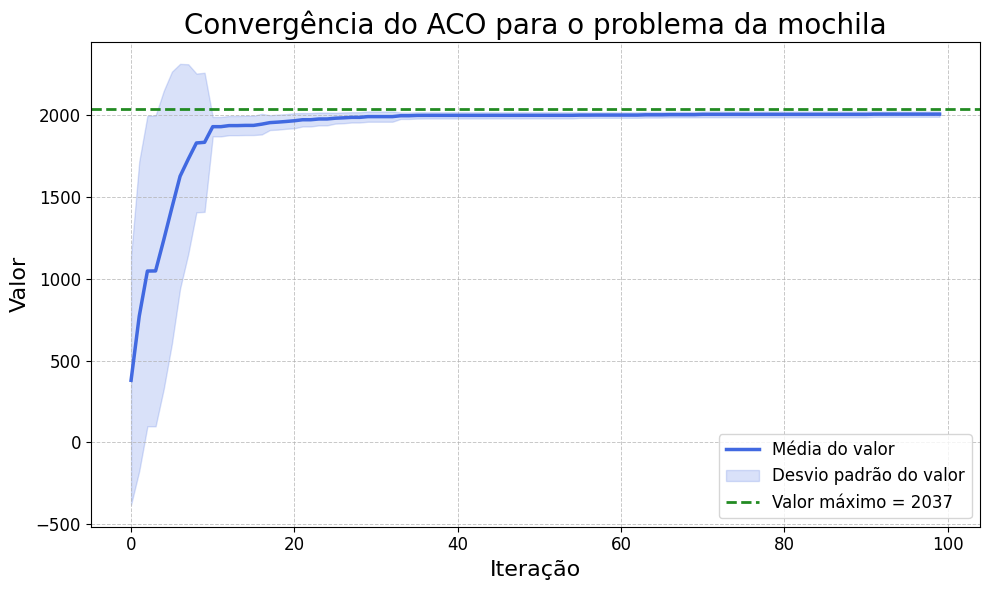

In [8]:
aco_stats.plot_convergence(
    title="Convergência do ACO para o problema da mochila",
    savefig="results/aco_convergence.png"
)